In [6]:
%matplotlib notebook
from kalman_experiments.model_selection import fit_kf_parameters
from kalman_experiments import SSPE
from kalman_experiments.kalman import PerturbedP1DMatsudaKF
from kalman_experiments.models import MatsudaParams, SingleRhythmModel, collect, gen_ar_noise_coefficients, ArNoise
import numpy as np
# Setup oscillatioins model and generate oscillatory signal
sim = SSPE.gen_sine_w_pink(10, 1000)
a = gen_ar_noise_coefficients(alpha=1.5, order=30)
kf = PerturbedP1DMatsudaKF(MatsudaParams(A=0.99, freq=8, sr=1000), q_s=0.1, psi=a, r_s=1, lambda_=0)
kf = fit_kf_parameters(sim.data, kf)


Fitting KF parameters:   0%|                                    | 0/800 [00:00<?, ?it/s]

nll, r2 = (array([[78.4534595]]), array([[10.09538847]]))


Fitting KF parameters:   0%|                            | 1/800 [00:01<22:40,  1.70s/it]

MatsudaParams(A=0.9879772012075986, freq=7.856912506304551, sr=1000) 0.09960347810227319 0.13029270007485724
nll, r2 = (array([[-17669.62290079]]), array([[8.75727902]]))


Fitting KF parameters:   0%|                            | 2/800 [00:03<22:53,  1.72s/it]

MatsudaParams(A=0.9911270082521774, freq=5.696212256800071, sr=1000) 0.08986115813565376 0.0814148039207845
nll, r2 = (array([[-20763.57936284]]), array([[3.36986125]]))


Fitting KF parameters:   0%|                            | 3/800 [00:05<22:49,  1.72s/it]

MatsudaParams(A=0.9946459799371804, freq=5.4218533822319115, sr=1000) 0.07709507001868567 0.06095145785633267
nll, r2 = (array([[-22789.38451638]]), array([[3.59299366]]))


Fitting KF parameters:   0%|▏                           | 4/800 [00:06<22:55,  1.73s/it]

MatsudaParams(A=0.9961726128548631, freq=5.523684800573867, sr=1000) 0.06491020108655285 0.04828180931444087
nll, r2 = (array([[-24587.47609182]]), array([[4.3508751]]))


Fitting KF parameters:   1%|▏                           | 5/800 [00:08<22:55,  1.73s/it]

MatsudaParams(A=0.9972476623828148, freq=5.66091894571904, sr=1000) 0.05435735228510827 0.03925879718018452
nll, r2 = (array([[-26232.8991284]]), array([[5.10057718]]))


Fitting KF parameters:   1%|▏                           | 6/800 [00:10<22:55,  1.73s/it]

MatsudaParams(A=0.9980237012452656, freq=5.765848732777801, sr=1000) 0.04559258859871523 0.03245707717774866
nll, r2 = (array([[-27709.63731553]]), array([[5.69165391]]))


Fitting KF parameters:   1%|▏                           | 7/800 [00:12<22:57,  1.74s/it]

MatsudaParams(A=0.9985681777388751, freq=5.837893218920496, sr=1000) 0.03849197487402268 0.02721798567322434
nll, r2 = (array([[-28976.49522409]]), array([[6.12026616]]))


Fitting KF parameters:   1%|▎                           | 8/800 [00:13<22:59,  1.74s/it]

MatsudaParams(A=0.9989435695368691, freq=5.886255998944157, sr=1000) 0.03284836918629868 0.02316845044959019
nll, r2 = (array([[-29989.33800103]]), array([[6.42084873]]))


Fitting KF parameters:   1%|▎                           | 9/800 [00:15<23:01,  1.75s/it]

MatsudaParams(A=0.9991995290869916, freq=5.918555647994189, sr=1000) 0.02844235931809325 0.020061228583631154
nll, r2 = (array([[-30718.39045368]]), array([[6.62790261]]))


Fitting KF parameters:   1%|▎                          | 10/800 [00:17<23:24,  1.78s/it]

MatsudaParams(A=0.9993728255354085, freq=5.940098653853203, sr=1000) 0.025065686448100203 0.017711748180676067
nll, r2 = (array([[-31163.16202377]]), array([[6.76894999]]))


Fitting KF parameters:   1%|▎                          | 11/800 [00:19<23:15,  1.77s/it]

MatsudaParams(A=0.9994896813112416, freq=5.954469300986055, sr=1000) 0.022527252000029047 0.015970401075458964
nll, r2 = (array([[-31359.49148579]]), array([[6.86437108]]))


Fitting KF parameters:   2%|▍                          | 12/800 [00:20<23:16,  1.77s/it]

MatsudaParams(A=0.999568363111205, freq=5.964068965156661, sr=1000) 0.02065466805943148 0.01471034398150821
nll, r2 = (array([[-31372.3023043]]), array([[6.92868102]]))


Fitting KF parameters:   2%|▍                          | 13/800 [00:22<23:08,  1.76s/it]

MatsudaParams(A=0.9996214023113928, freq=5.970501611299465, sr=1000) 0.019296058590443976 0.013823027870158898
nll, r2 = (array([[-31276.19837185]]), array([[6.97197525]]))


Fitting KF parameters:   2%|▍                          | 14/800 [00:24<23:05,  1.76s/it]

MatsudaParams(A=0.9996573071629042, freq=5.974836763706564, sr=1000) 0.01832236764279341 0.01321726114131399
nll, r2 = (array([[-31135.16539782]]), array([[7.00116883]]))


Fitting KF parameters:   2%|▌                          | 15/800 [00:26<24:00,  1.84s/it]

MatsudaParams(A=0.9996818118181068, freq=5.977786328117134, sr=1000) 0.017628692798442064 0.012819018678492613
nll, r2 = (array([[-30991.80941098]]), array([[7.02094992]]))


Fitting KF parameters:   2%|▌                          | 16/800 [00:28<23:49,  1.82s/it]

MatsudaParams(A=0.9996987591162642, freq=5.979823075745366, sr=1000) 0.017133554996699704 0.01257050197755413
nll, r2 = (array([[-30867.67939604]]), array([[7.03447405]]))


Fitting KF parameters:   2%|▌                          | 17/800 [00:30<23:40,  1.81s/it]

MatsudaParams(A=0.9997107127673313, freq=5.981260080056548, sr=1000) 0.01677620883396238 0.012428173782169916
nll, r2 = (array([[-30769.53196198]]), array([[7.04385388]]))


Fitting KF parameters:   2%|▌                          | 18/800 [00:31<23:35,  1.81s/it]

MatsudaParams(A=0.9997193766769146, freq=5.982304009457484, sr=1000) 0.016512871732119676 0.01236018859957562
nll, r2 = (array([[-30696.14314389]]), array([[7.05049814]]))


Fitting KF parameters:   2%|▌                          | 18/800 [00:33<24:23,  1.87s/it]

MatsudaParams(A=0.9997258796483154, freq=5.983090848445104, sr=1000) 0.016312805701328155 0.01234376277510417


In [ ]:
%debug

> /home/altukhov/Code/python/kalman_experiments/src/kalman_experiments/model_selection.py(254)phi_osc_only_upd()
    252     D = S["11"][0, 0] + S["11"][1, 1]
    253     f = C / B
--> 254     assert f > 0
    255     Amp = np.sqrt(B**2 + C**2) / A
    256     q_s = np.sqrt(0.5 * (D - Amp**2 * A) / n)

ipdb> f
-1.1072687731750816e-06
ipdb> C
-0.7656523163805575
ipdb> B
691478.2886769737
ipdb> S["10"]
array([[ 4.31635157e+05, -2.98712169e+00,  2.84200641e+04, ...,
         8.29397792e+03,  6.70207993e+03,  5.07282170e+03],
       [-3.75277400e+00,  2.59843132e+05, -1.26150053e+01, ...,
        -1.01968819e+01, -1.01092295e+01, -1.00222098e+01],
       [ 2.84148818e+04, -1.22413753e+01,  3.54895915e+04, ...,
         2.36542380e+04,  2.31971840e+04,  2.27353686e+04],
       ...,
       [ 1.13594348e+04, -1.03749126e+01,  2.45571004e+04, ...,
         3.53917485e+04,  3.47516263e+04,  3.42126884e+04],
       [ 9.84575672e+03, -1.02858463e+01,  2.41062109e+04, ...,
         3.62970227e+04,

In [2]:
kf.psi / np.linalg.norm(kf.psi)

array([ 0.97812946, -0.08524849,  0.12040778, -0.0313065 ,  0.07316462,
        0.00312547,  0.03056982,  0.04412366,  0.03146193,  0.01877306,
        0.02165963,  0.0084746 ,  0.03943887,  0.02146708,  0.03967004,
        0.01636981,  0.00861142,  0.01310525,  0.01370287, -0.0259578 ,
       -0.00974137, -0.01751398, -0.00665553, -0.00337771, -0.01116423,
       -0.0172032 , -0.0295367 , -0.0301056 , -0.03719221, -0.0372084 ])

In [3]:
a/np.linalg.norm(a)

array([9.90118181e-01, 1.23764773e-01, 5.15686553e-02, 2.90073686e-02,
       1.88547896e-02, 1.33554760e-02, 1.00166070e-02, 7.82547419e-03,
       6.30385421e-03, 5.20067972e-03, 4.37329886e-03, 3.73552611e-03,
       3.23266682e-03, 2.82858347e-03, 2.49858207e-03, 2.22529965e-03,
       1.99622469e-03, 1.80214729e-03, 1.63616004e-03, 1.49299603e-03,
       1.36857970e-03, 1.25971540e-03, 1.16386749e-03, 1.07900215e-03,
       1.00347200e-03, 9.35930619e-04, 8.75268449e-04, 8.20564171e-04,
       7.71047368e-04, 7.26069605e-04])

<IPython.core.display.Javascript object>


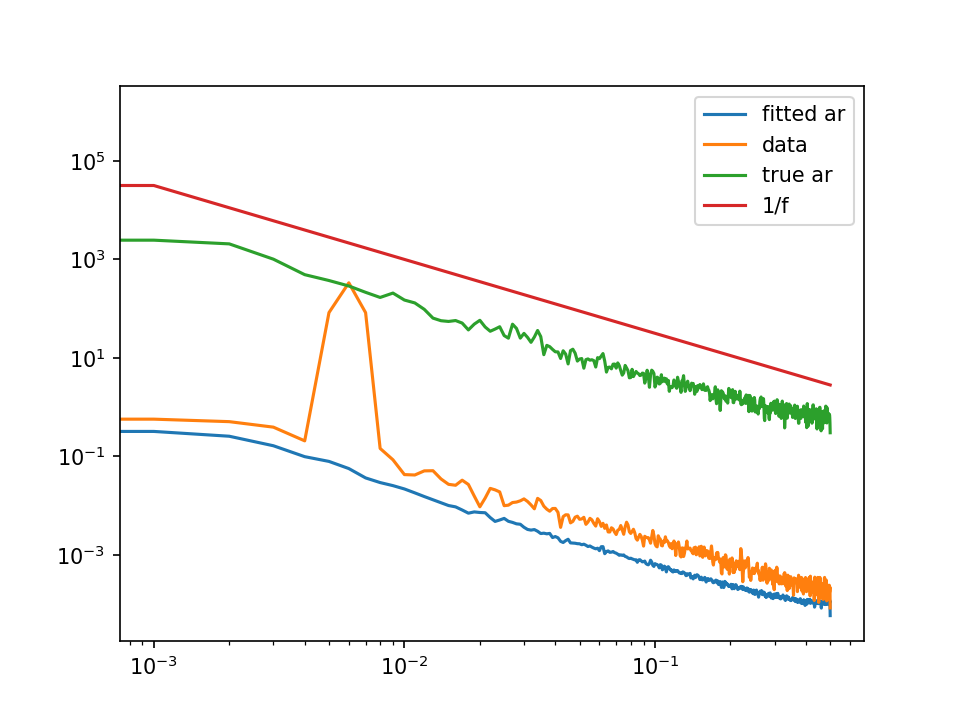

In [7]:
from collections import deque
ar_states = deque(np.random.randn(len(kf.psi)))
gen_noise = []
for i in range(100000):
    next_state = np.array(ar_states) @ kf.psi + np.random.randn() * kf.r_s
    gen_noise.append(next_state)
    ar_states.pop()
    ar_states.appendleft(next_state)
    
from scipy.signal import welch
import matplotlib.pyplot as plt

noise_model = ArNoise(x0=np.random.rand(30), alpha=1.5, order=30, s=1)
noise_sim = collect(noise_model, 10 * 1000)
freqs, psd = welch(gen_noise, nperseg=1000)
_, psd_data = welch(sim.data, nperseg=1000)
_, psd_ar_noise = welch(noise_sim, nperseg=1000)
plt.loglog(freqs, psd, label="fitted ar")
plt.loglog(freqs, psd_data, label="data")
plt.loglog(freqs, psd_ar_noise, label="true ar")
plt.loglog(freqs, [1/f**1.5 if f else 1000000 for f in freqs ], label="1/f")
plt.legend()
plt.show()
    
    

In [4]:
kf.M

MatsudaParams(A=0.9952916912462901, freq=6.030948897325629, sr=1000)

In [5]:
kf.q_s

0.8827553450381993

In [6]:
kf.r_s

0.3520707527113655